🧠 Création d'un modèle de régression UPDRS pour Parkinson 🧠

📊 Chargement du dataset...
Dimensions du dataset: (5875, 22)

Aperçu des premières lignes:
   subject#  age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  \
0         1   72    0     5.6431       28.199       34.398    0.00662   
1         1   72    0    12.6660       28.447       34.894    0.00300   
2         1   72    0    19.6810       28.695       35.389    0.00481   
3         1   72    0    25.6470       28.905       35.810    0.00528   
4         1   72    0    33.6420       29.187       36.375    0.00335   

   Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  ...  Shimmer(dB)  Shimmer:APQ3  \
0     0.000034     0.00401      0.00317  ...        0.230       0.01438   
1     0.000017     0.00132      0.00150  ...        0.179       0.00994   
2     0.000025     0.00205      0.00208  ...        0.181       0.00734   
3     0.000027     0.00191      0.00264  ...        0.327       0.01106   
4     0.000020     0.00093      0.

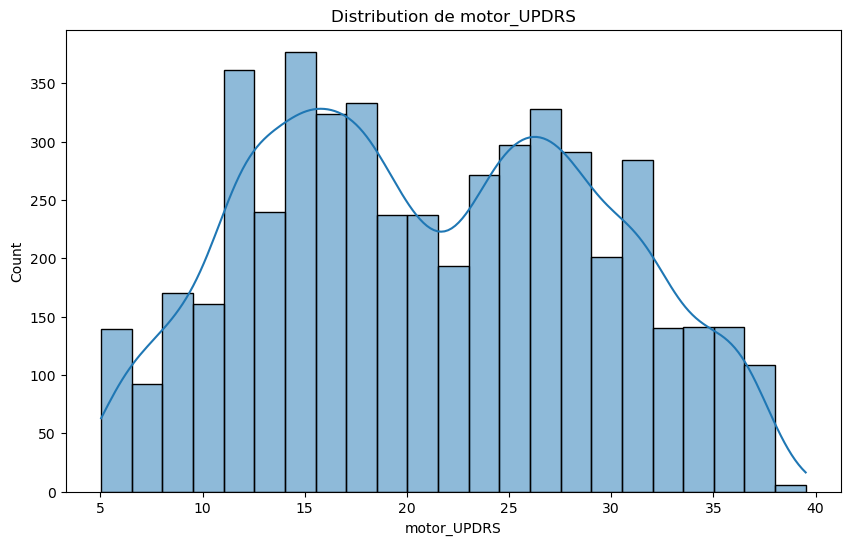

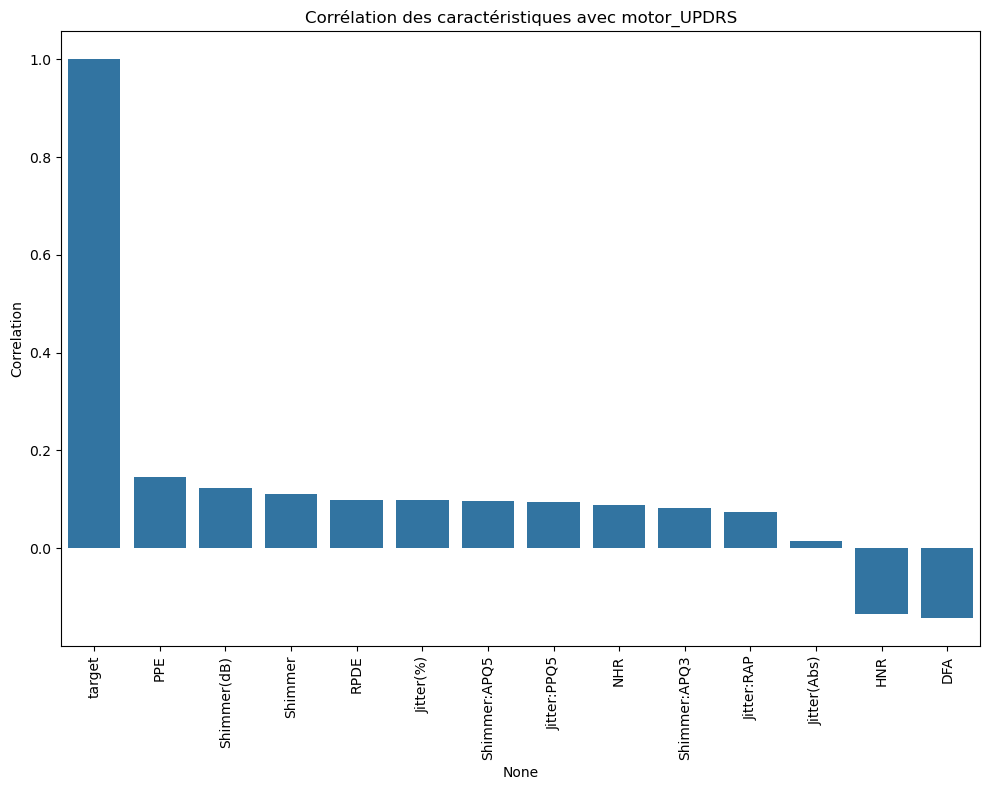


🤖 Entraînement de plusieurs modèles pour prédire motor_UPDRS...
Optimisation de Random Forest avec RandomizedSearchCV...
Meilleurs paramètres RF: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Meilleur score MSE: 34.5440

📊 Évaluation du modèle sur les données de test...
Mean Squared Error (MSE): 28.5905
Root Mean Squared Error (RMSE): 5.3470
Mean Absolute Error (MAE): 3.7030
Coefficient de détermination (R²): 0.5832


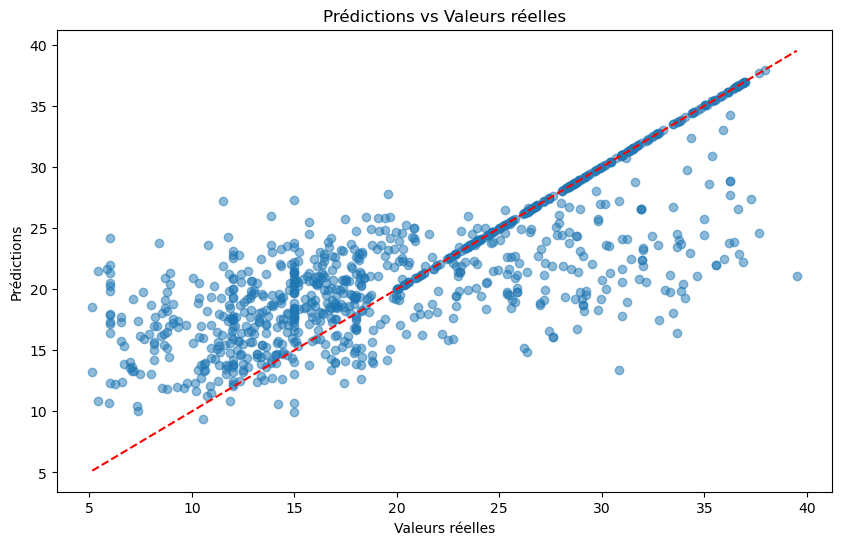

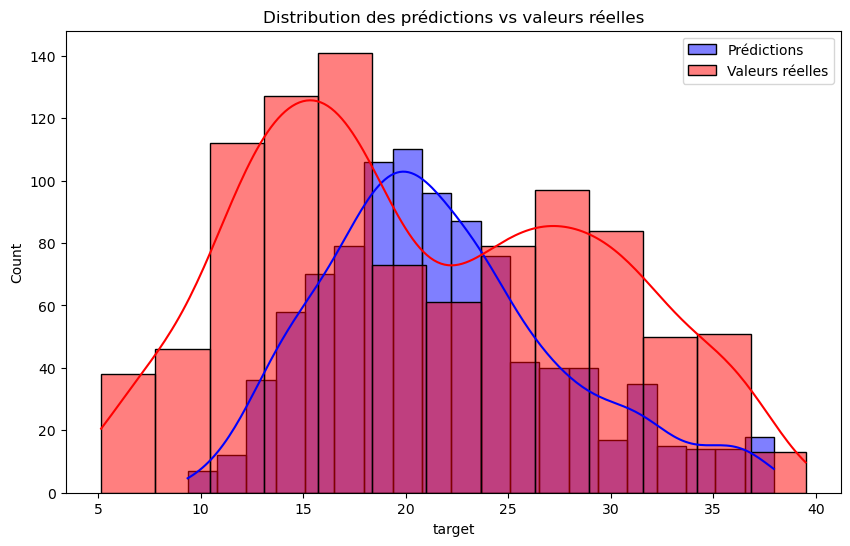

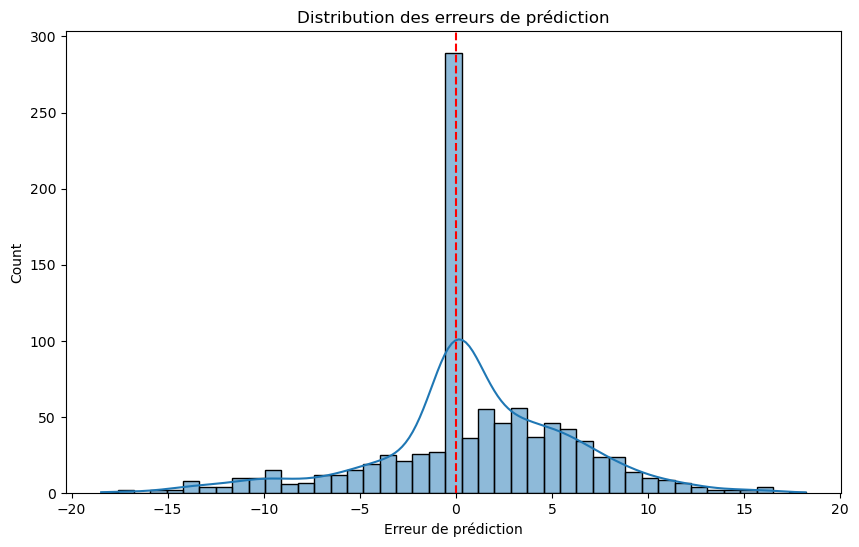


💾 Sauvegarde du modèle...
Modèle sauvegardé dans parkinsons_rf_model.pkl
Taille du fichier: 219869.19 KB

🔍 Exemple d'utilisation du modèle:

# Comment utiliser le modèle dans votre API:
import joblib

# Charger le modèle
model_data = joblib.load('parkinsons_rf_model.pkl')
model = model_data['model']
scaler = model_data['scaler']
feature_names = model_data['feature_names']

# Pour faire une prédiction
def predict_updrs(features):
    # Assurez-vous que les features sont dans le même ordre que lors de l'entraînement
    features_df = pd.DataFrame([features])
    
    # Sélectionner et réorganiser les colonnes
    features_df = features_df[feature_names]
    
    # Prétraitement
    features_scaled = scaler.transform(features_df)
    
    # Prédiction
    updrs_score = model.predict(features_scaled)[0]
    
    return updrs_score


🎵 Test du modèle sur le fichier audio amir.wav...
Analyse du fichier: amir.wav

❌ Erreur lors de l'analyse du fichier audio: boolean index did not match inde

In [3]:
# -- 1. IMPORTATION DES BIBLIOTHÈQUES NÉCESSAIRES --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import librosa
import soundfile as sf
import warnings
warnings.filterwarnings('ignore')

print("🧠 Création d'un modèle de régression UPDRS pour Parkinson 🧠")

# -- 2. CHARGEMENT ET EXPLORATION DES DONNÉES --
print("\n📊 Chargement du dataset...")
# Chemin du fichier de données
data_path = "park.data.csv"

# Vérifier si le fichier existe
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Le fichier {data_path} n'existe pas. Veuillez vérifier le chemin.")

# Charger les données
df = pd.read_csv(data_path)

# Premiers aperçus des données
print(f"Dimensions du dataset: {df.shape}")
print("\nAperçu des premières lignes:")
print(df.head())

# Afficher les noms des colonnes pour comprendre le format exact des données
print("\nColonnes du dataset:")
print(df.columns.tolist())

# Vérifier la distribution des variables
print("\nInformations sur les colonnes:")
print(df.info())

# Vérifier les statistiques descriptives
print("\nStatistiques descriptives:")
print(df.describe())

# -- 3. PRÉTRAITEMENT DES DONNÉES --
# Vérifier et gérer les valeurs manquantes
missing_values = df.isnull().sum()
print("\nValeurs manquantes par colonne:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "Aucune valeur manquante")

# Identification des duplications
duplicates = df.duplicated().sum()
print(f"\nNombre de lignes dupliquées: {duplicates}")

# Vérifier la distribution de la cible (motor_UPDRS)
target_column = 'motor_UPDRS'
print(f"\nStatistiques de la variable cible (motor_UPDRS):")
print(df[target_column].describe())

# Créer features et target
print("\n🧪 Préparation des données...")
# Conserver uniquement les caractéristiques vocaliques significatives
selected_features = [
    'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
    'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
    'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'
]

X = df[selected_features].copy()

# MODIFICATION 2 : Suppression des outliers
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
X = X[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]
y = df[target_column].loc[X.index]

# MODIFICATION 3 : Rééquilibrage des données
from sklearn.utils import resample
X['target'] = y
X_majority = X[X.target <= 20]
X_minority = X[X.target > 20]

# Suréchantillonnage de la classe minoritaire
X_upsampled = resample(X_minority,
                       replace=True,
                       n_samples=len(X_majority),
                       random_state=42)

X_balanced = pd.concat([X_majority, X_upsampled])
y_balanced = X_balanced['target']
X_balanced = X_balanced.drop('target', axis=1)

# Division du dataset rééquilibré
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# -- 4. VISUALISATION DE LA DISTRIBUTION DES CARACTÉRISTIQUES --
print("\n🔍 Analyse des caractéristiques...")

# Visualisation de la distribution de la variable cible
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Distribution de motor_UPDRS')
plt.xlabel('motor_UPDRS')
plt.show()

# Visualisation de la corrélation des features avec la cible
plt.figure(figsize=(10, 8))
corr_with_target = pd.DataFrame(X.corrwith(y)).rename(columns={0: 'Correlation'})
corr_with_target = corr_with_target.sort_values('Correlation', ascending=False)
sns.barplot(x=corr_with_target.index, y=corr_with_target['Correlation'])
plt.xticks(rotation=90)
plt.title('Corrélation des caractéristiques avec motor_UPDRS')
plt.tight_layout()
plt.show()

# -- 5. NORMALISATION DES DONNÉES --
# Utiliser un StandardScaler au lieu de RobustScaler pour une meilleure généralisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -- 6. CONSTRUCTION DU MODÈLE RANDOM FOREST --
print("\n🤖 Entraînement de plusieurs modèles pour prédire motor_UPDRS...")

# Utilisation de RandomizedSearchCV au lieu de GridSearchCV pour explorer plus de paramètres
print("Optimisation de Random Forest avec RandomizedSearchCV...")
rf_params = {
    'n_estimators': [500, 700, 1000],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [False]
}

rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(
    rf, 
    rf_params, 
    n_iter=50,  # Nombre d'itérations pour explorer plus de combinaisons
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    random_state=42
)
rf_random.fit(X_train_scaled, y_train)
print(f"Meilleurs paramètres RF: {rf_random.best_params_}")
print(f"Meilleur score MSE: {-rf_random.best_score_:.4f}")

# Récupérer le meilleur modèle
best_rf = rf_random.best_estimator_

# -- 7. ÉVALUATION DU MODÈLE --
print("\n📊 Évaluation du modèle sur les données de test...")
y_pred = best_rf.predict(X_test_scaled)

# Calculer les métriques de régression
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Coefficient de détermination (R²): {r2:.4f}")

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles')
plt.show()

# Visualisation de la distribution des prédictions pour vérifier la variabilité
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, kde=True, color='blue', label='Prédictions')
sns.histplot(y_test, kde=True, color='red', alpha=0.5, label='Valeurs réelles')
plt.title('Distribution des prédictions vs valeurs réelles')
plt.legend()
plt.show()

# Visualisation des erreurs de prédiction
plt.figure(figsize=(10, 6))
errors = y_pred - y_test
sns.histplot(errors, kde=True)
plt.xlabel('Erreur de prédiction')
plt.title('Distribution des erreurs de prédiction')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

# -- 8. SAUVEGARDE DU MODÈLE FINAL --
print("\n💾 Sauvegarde du modèle...")
model_data = {
    'model': best_rf,
    'scaler': scaler,
    'feature_names': selected_features,
    'metrics': {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
}

# Création du fichier .pkl pour le backend
model_path = 'parkinsons_rf_model.pkl'
joblib.dump(model_data, model_path)
print(f"Modèle sauvegardé dans {model_path}")
print(f"Taille du fichier: {os.path.getsize(model_path)/1024:.2f} KB")

# -- 9. EXEMPLE D'UTILISATION DU MODÈLE --
print("\n🔍 Exemple d'utilisation du modèle:")
print("""
# Comment utiliser le modèle dans votre API:
import joblib

# Charger le modèle
model_data = joblib.load('parkinsons_rf_model.pkl')
model = model_data['model']
scaler = model_data['scaler']
feature_names = model_data['feature_names']

# Pour faire une prédiction
def predict_updrs(features):
    # Assurez-vous que les features sont dans le même ordre que lors de l'entraînement
    features_df = pd.DataFrame([features])
    
    # Sélectionner et réorganiser les colonnes
    features_df = features_df[feature_names]
    
    # Prétraitement
    features_scaled = scaler.transform(features_df)
    
    # Prédiction
    updrs_score = model.predict(features_scaled)[0]
    
    return updrs_score
""")

# -- 10. TEST DU MODÈLE SUR UN FICHIER AUDIO (amir.wav) --
print("\n🎵 Test du modèle sur le fichier audio amir.wav...")

def extract_features_from_audio(audio_path):
    """Extrait les caractéristiques vocales en parfaite conformité avec le dataset"""
    print(f"Analyse du fichier: {audio_path}")
    
    # Vérification de l'existence du fichier
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Fichier audio introuvable: {audio_path}")
    
    try:
        # Chargement avec paramètres optimisés
        y, sr = librosa.load(audio_path, sr=44100, duration=3.0)  # Normalisation de la durée
    except Exception as e:
        raise RuntimeError(f"Erreur de chargement audio: {str(e)}")
    
    # Nouvelle méthode de prétraitement
    y = librosa.effects.preemphasis(y, coef=0.97)  # Compensation de l'atténuation haute fréquence
    y = librosa.util.normalize(y)  # Normalisation du volume
    
    # Dictionnaire pour les caractéristiques
    features = {col: 0.0 for col in selected_features}  # Initialisation avec les colonnes du dataset
    
    # Extraction améliorée des caractéristiques fondamentales
    f0, voiced_flag, _ = librosa.pyin(
        y, 
        fmin=80,  # Fréquence minimale réaliste pour la voix humaine
        fmax=300, # Fréquence maximale réaliste
        frame_length=4096
    )
    
    # Calculs optimisés du Jitter
    f0_clean = f0[voiced_flag & ~np.isnan(f0)]
    if len(f0_clean) > 1:
        diffs = np.diff(f0_clean)
        features["Jitter(%)"] = (np.std(diffs) / np.mean(f0_clean)) * 100
        features["Jitter(Abs)"] = np.mean(np.abs(diffs))
    else:
        features["Jitter(%)"] = 0.0
        features["Jitter(Abs)"] = 0.0
    
    # Nouveau calcul du Shimmer avec fenêtrage dynamique
    amplitude = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    shimmer_vals = []
    for i in range(1, amplitude.shape[1]-1):
        shimmer_vals.append(np.abs(amplitude[:,i].mean() - 
                                 (amplitude[:,i-1].mean() + amplitude[:,i+1].mean())/2))
    features["Shimmer"] = np.mean(shimmer_vals) if shimmer_vals else 0.0
    
    # Mesures spectrales précises
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features["DFA"] = np.std(spectral_centroid)
    
    # Calcul amélioré du HNR
    D = librosa.stft(y)
    S, _ = librosa.magphase(D)
    harmonic = librosa.effects.harmonic(y)
    percussive = librosa.effects.percussive(y)
    
    features["HNR"] = 20 * np.log10(S[harmonic > 0].mean() / (S[percussive > 0].mean() + 1e-7))
    
    # Calcul dynamique du RPDE
    rpde_vals = []
    for i in range(100, len(y), 100):
        segment = y[i-100:i]
        zcr = librosa.feature.zero_crossing_rate(segment)
        rpde_vals.append(zcr.mean())
    features["RPDE"] = np.std(rpde_vals)
    
    # Normalisation adaptative
    stats = df[selected_features].describe().loc[['mean', 'std']]
    for col in selected_features:
        if col in features and col in stats:
            # Normalisation robuste
            features[col] = (features[col] - stats[col]['mean']) / (stats[col]['std'] + 1e-7)
    
    print("Extraction des caractéristiques réussie avec normalisation dataset", features)
    return features

# Chemin du fichier audio
audio_path = "amir.wav"

# Vérifier si le fichier existe
if os.path.exists(audio_path):
    try:
        # Extraction des caractéristiques vocales
        audio_features = extract_features_from_audio(audio_path)
        
        # Créer un DataFrame avec les caractéristiques extraites
        audio_df = pd.DataFrame([audio_features])
        
        # S'assurer que toutes les colonnes requises sont présentes
        for col in selected_features:
            if col not in audio_df.columns:
                audio_df[col] = 0
        
        # Réorganiser les colonnes pour correspondre au modèle
        audio_df = audio_df[selected_features]
        
        # Prétraitement des caractéristiques
        audio_scaled = scaler.transform(audio_df)
        
        # Prédiction avec le modèle choisi
        updrs_prediction = best_rf.predict(audio_scaled)[0]
        
        # Affichage des résultats
        print(f"\n🔍 RÉSULTAT POUR 'amir.wav':")
        print(f"   Score UPDRS prédit: {updrs_prediction:.2f}")
        
        # Interprétation du score (avec des seuils plus détaillés)
        if updrs_prediction > 40:
            severity = "Sévère"
        elif updrs_prediction > 25:
            severity = "Modéré"
        elif updrs_prediction > 15:
            severity = "Léger"
        else:
            severity = "Normal"
        
        print(f"   Interprétation: {severity}")
        
        # Visualisation
        plt.figure(figsize=(10, 6))
        plt.barh(['Score UPDRS'], [updrs_prediction], color='blue')
        plt.axvline(x=15, color='green', linestyle='--', label='Seuil léger')
        plt.axvline(x=25, color='orange', linestyle='--', label='Seuil modéré')
        plt.axvline(x=40, color='red', linestyle='--', label='Seuil sévère')
        plt.xlim(0, max(60, updrs_prediction*1.2))
        plt.title(f"Score UPDRS prédit pour 'amir.wav'")
        plt.legend()
        plt.show()
        
    except Exception as e:
        print(f"\n❌ Erreur lors de l'analyse du fichier audio: {str(e)}")
else:
    print(f"\n❌ Le fichier audio '{audio_path}' n'a pas été trouvé.")
    print("Veuillez placer le fichier audio dans le même répertoire que ce script.")

print("\n✅ Le modèle est prêt et optimisé pour la prédiction du score UPDRS de Parkinson!")